<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/observation_tools/promptfoo/promptfoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

#  LLM Evaluations with Promptfoo and UpTrain

[Promptfoo](https://www.promptfoo.dev/) is an LLM observability tool that helps observe your LLM experiments. Using Promptfoo you can compare prompts and model outputs side-by-side, or integrate the library into your existing test/CI workflow.

This notebook demonstrates how to observe your LLM experiments for latency, tokens and cost using Promptfoo.
Further using UpTrain we can evaluate over metrics such as:
1. [Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance): Evaluates how relevant the retrieved context is to the question specified.

2. [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy): Evaluates whether the response generated is factually correct and grounded by the provided context.

3. [Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness): Evaluates whether the response has answered all the aspects of the question specified

You can look at the complete list of UpTrain's supported metrics [here](https://docs.uptrain.ai/predefined-evaluations/overview)

## Prerequisites
You need `npx` to run this integration.

Please check if you have npx installed using this command in your terminal: `npx -v`

If not, have a look at this [documentation](https://www.npmjs.com/package/npx) 

## Overview

In this notebook we will be testing out a set of 2 prompts.
Further we will be comparing these prompts 

These prompts answers user's query based on a retrieved context.

We will be using these Uptrain's [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy) to evaluate the outputs generated using these prompts

## How to do it?

In [ ]:
from uptrain import Evals

In [ ]:
evals_list = [Evals.CONTEXT_RELEVANCE, Evals.RESPONSE_COMPLETENESS, Evals.RESPONSE_CONCISENESS , Evals.VALID_RESPONSE,Evals.RESPONSE_RELEVANCE]
evals_weight = [1,4,2,1,6]

providers = ['openai:chat:gpt-3.5-turbo-0613', 'openai:chat:gpt-4']
threshold = 0.9

data = [
    {
      'question' : 'Which is the most popular global sport?',
      'context' : 'Football is undoubtedly on of the most popular sport with major events like the FIFA World Cup and sports personalities like Ronaldo and Messi, drawing a followership of more than 4 billion people.',
    },
    {
      'question' : 'What causes diabetes?',
      'context' : 'Diabetes is a metabolic disorder characterized by high blood sugar levels. It is primarily caused by a combination of genetic and environmental factors, including obesity and lack of physical activity.',
    },
    {
      'question' : 'What are the symptoms of a heart attack?',
      'context' : 'A heart attack, or myocardial infarction, occurs when the blood supply to the heart muscle is blocked. Symptoms of a heart attack may include chest pain or discomfort, shortness of breath, nausea, lightheadedness, and pain or discomfort in one or both arms, the jaw, neck, or back.',
    }
]

In [ ]:
prompts ="""
Answer the following user query using the retrieved context:
{{question}}
The retrieved document has the following text:
{{context}}

Answer:
---
Answer the following user query using the retrieved context:
{{question}}
The retrieved document has the following text:
{{context}}
The answer should support information from the retrieved context and should answer the query completely.
Answer:
"""

In [ ]:
from uptrain import EvalPromptfoo

In [ ]:
EvalPromptfoo().evaluate(
    evals_list=evals_list, 
    evals_weight=evals_weight, 
    input_data=data, 
    threshold=threshold, 
    prompts=prompts, 
    providers=providers, 
    redirect_webview=True
)

## View the Output in Web Browser

You can view these results on your Web Browser by clicking on the link: http://localhost:15500

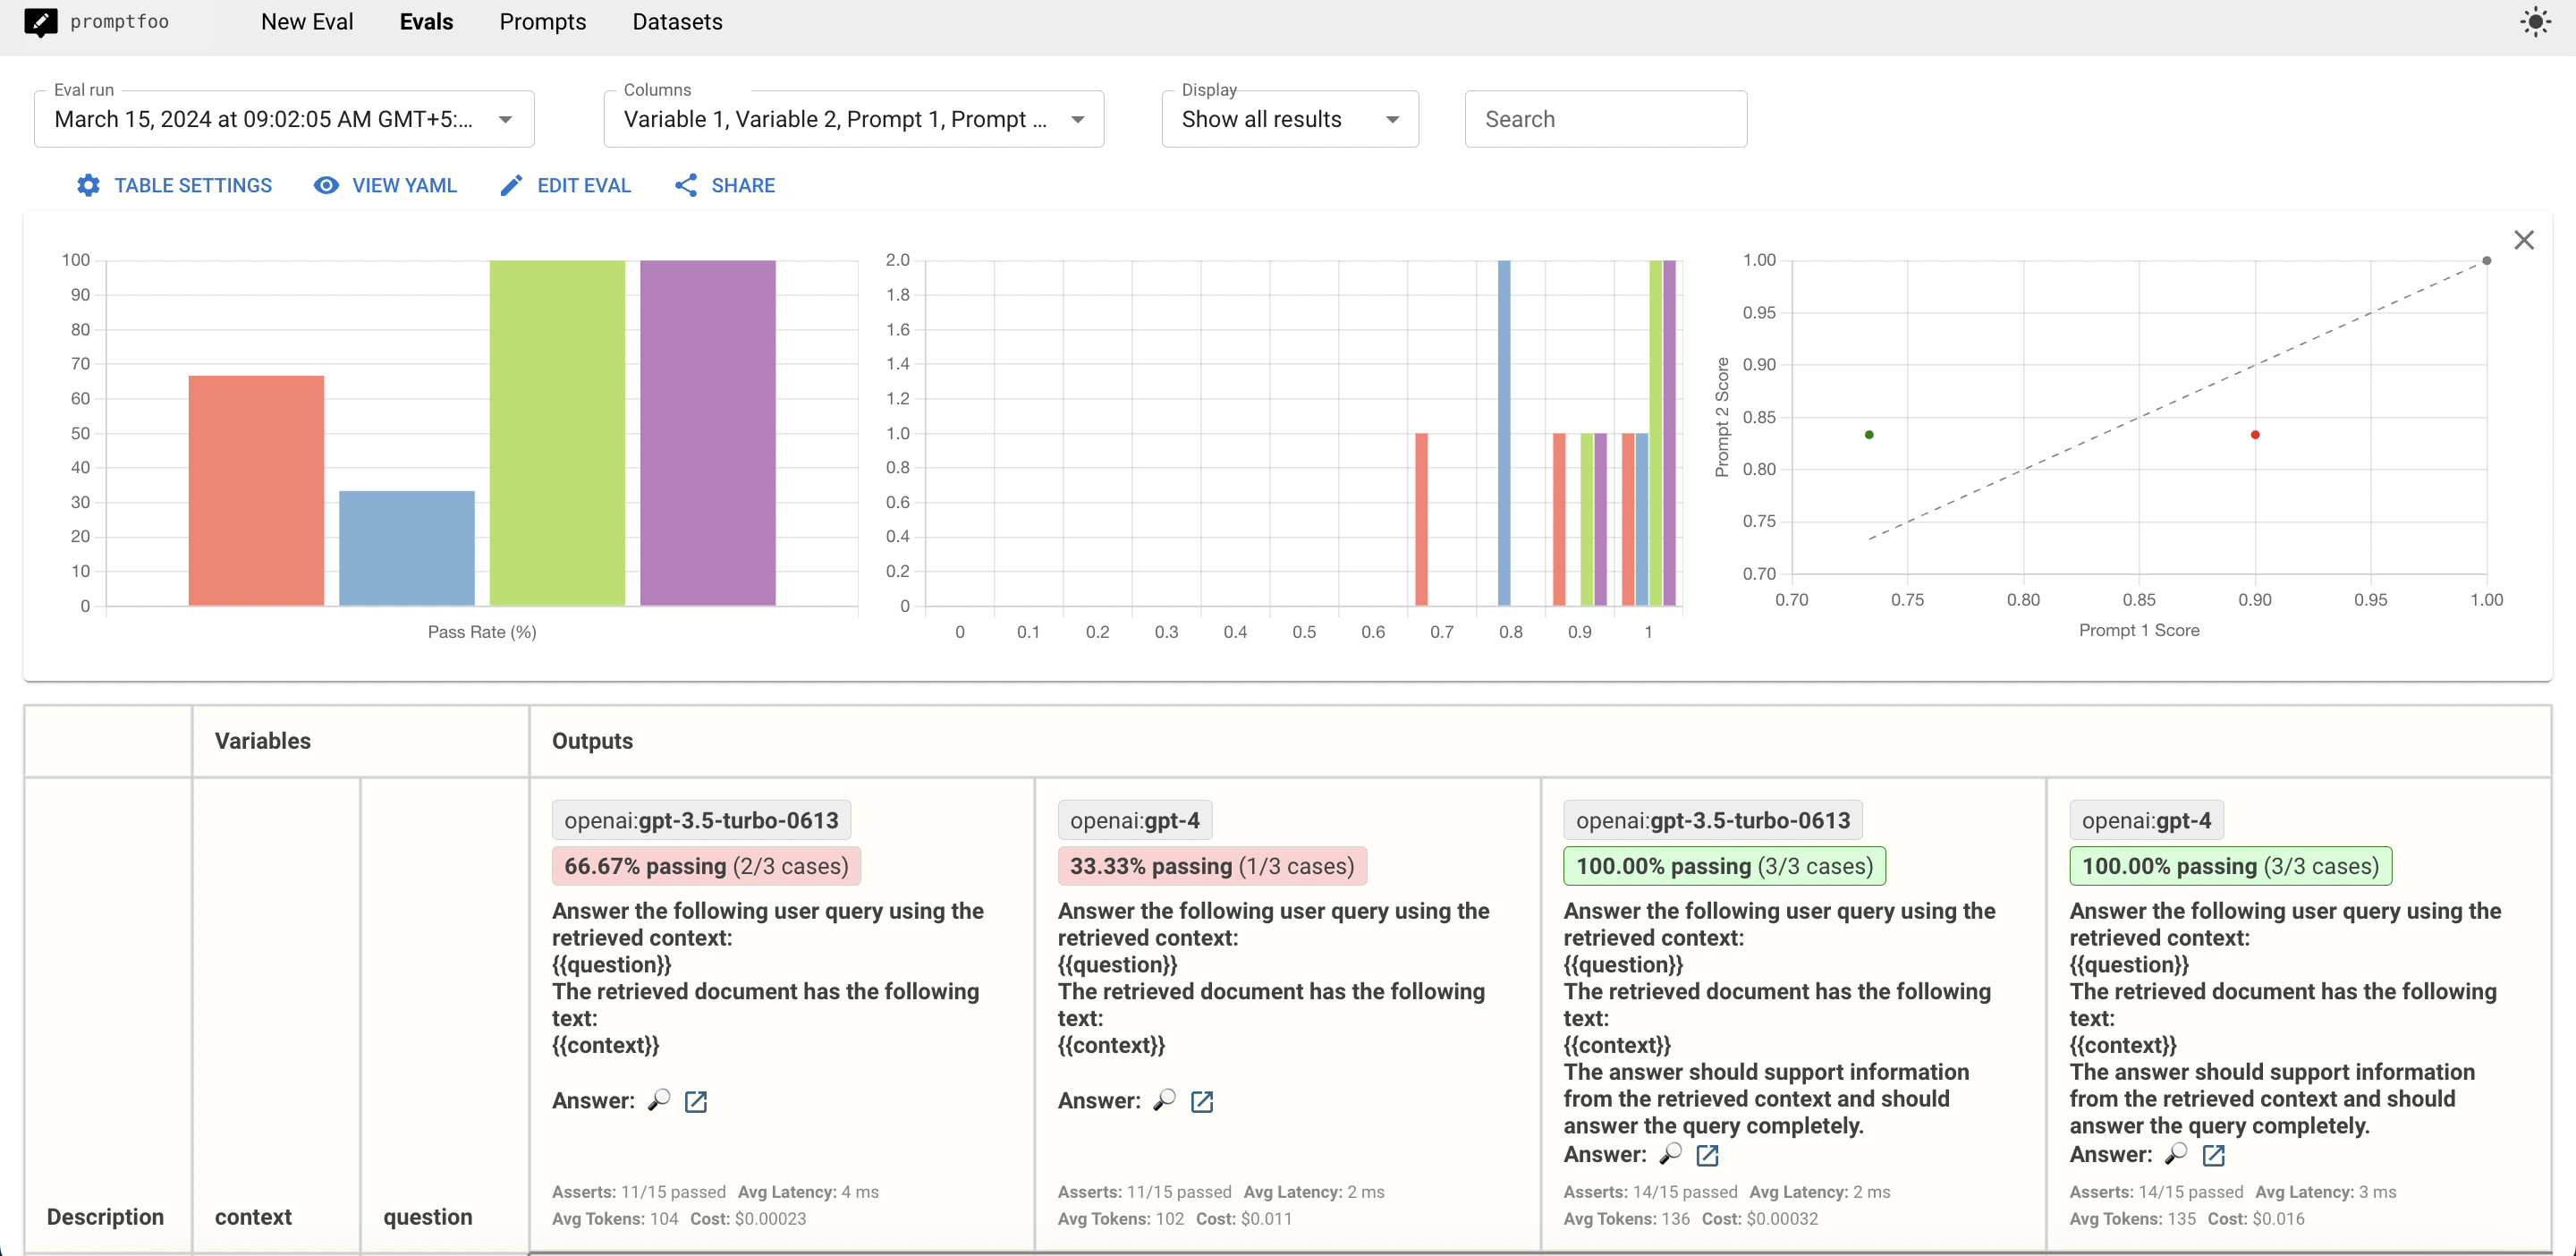